# 2nd order servo model

* instead of full state x observation, only position can be observed

In [15]:
import numpy
import scipy.linalg
import matplotlib.pyplot as plt

#2nd order state space model
#dx = Ax + Bu
#y  = Cx

#dv   = -1.0/tau*v + amp/tau*u
#dpos = v

tau = 1.9
amp = 3.1

#fill matrices
a = numpy.zeros((2, 2))
b = numpy.zeros((2, 1))
c = numpy.zeros((1, 2))

a[0][0] = -1.0/tau
a[0][1] = 0.0
a[1][0] = 1.0
a[1][1] = 0.0

b[0][0] = amp/tau

c[0][1] = 1.0


print(a)
print(b)
print(c)

[[-0.52631579  0.        ]
 [ 1.          0.        ]]
[[1.63157895]
 [0.        ]]
[[0. 1.]]


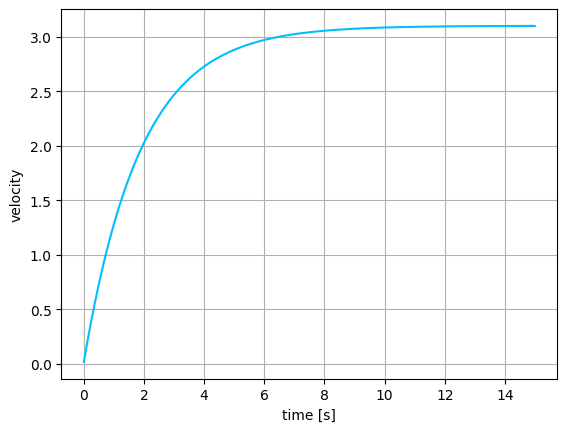

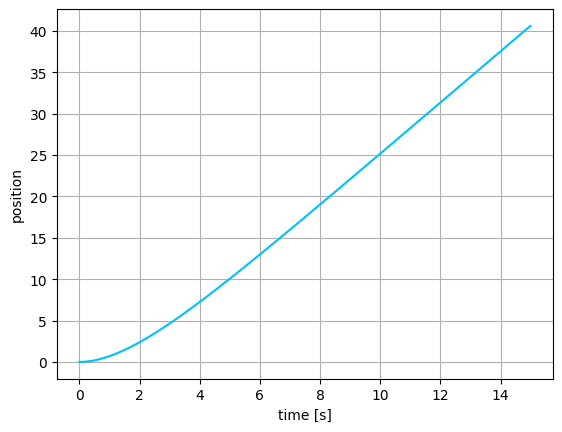

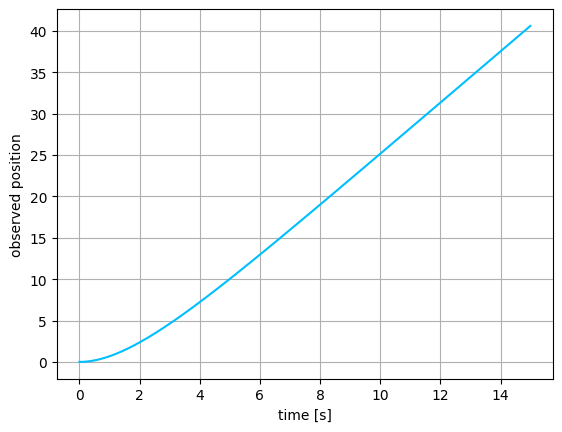

In [16]:
#open loop step response
dt          = 0.01
steps       = 1500
t_result    = numpy.arange(steps)*dt

#initial state
x           = numpy.zeros((2, 1))

#resulted states for ploting
x_result    = numpy.zeros((steps, 2))
y_result    = numpy.zeros((steps, 2))

for i in range(steps):
    u = numpy.ones((1, 1))

    dx = a@x + b@u
    y  = c@x
    x  = x + dx*dt
    
    x_result[i] = x[:, 0]
    y_result[i] = y[:, 0]

#plot step response
plt.clf()
plt.ylabel("velocity")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 0], color="deepskyblue")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("position")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 1], color="deepskyblue")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("observed position")
plt.xlabel("time [s]")
plt.plot(t_result, y_result[:, 1], color="deepskyblue")
plt.grid()
plt.show()

# LQG with integral action

## controller structure 

![diagram](../doc/diagrams/control-lqgi.png)


algorithm : same as LQG, modification :
* added error integration, and scaling matrix H



In [17]:
#controller criterion : weight diagonal matrices
q = numpy.array([ [1.0, 0.0], [0.0, 1.0] ] )
r = numpy.array( [ [0.5] ]) 
w = numpy.array( [[0.25]] )


#solve LQR controller, matrix K and G

n = a.shape[0]  #system order
m = b.shape[1]  #inputs count
k = c.shape[0]  #outputs count

a_aug = numpy.zeros((n + k, n + k))
b_aug = numpy.zeros((n + k, m))

q_aug = numpy.zeros(a_aug.shape)

#create augmented matrices, add state integral term
a_aug               = numpy.zeros((n+k, n+k))
a_aug[0:n, 0:n]     = a
a_aug[n:, 0:n]      = c

b_aug               = numpy.zeros((n+k, m))
b_aug[0:n, 0:m]     = b

q_aug               = numpy.zeros((n+k, n+k))
q_aug[0:n, 0:n]     = q

#this number effects controller agresivity
numpy.fill_diagonal(q_aug[n:, n:], 10.0)


print("a_aug = ")
print(a_aug, "\n")
print("b_aug = ")
print(b_aug, "\n")
print("q_aug = ")
print(q_aug, "\n")


#solve common LQR

#continnuous algebraic Riccati equation
p = scipy.linalg.solve_continuous_are(a_aug, b_aug, q_aug, r)
# compute the LQR gain matrix
kh =  scipy.linalg.inv(r) * (b_aug.T@p) 

#split state feedback K term and integral H term
k = kh[:, 0:n]
h = kh[:, n:]

#print control matrices
print(k)
print(h)


a_aug = 
[[-0.52631579  0.          0.        ]
 [ 1.          0.          0.        ]
 [ 0.          1.          0.        ]] 

b_aug = 
[[1.63157895]
 [0.        ]
 [0.        ]] 

q_aug = 
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0. 10.]] 

[[2.61350406 5.31612076]]
[[4.47213595]]


In [18]:
# solve Kalman observer, matrix F
p = scipy.linalg.solve_continuous_are(a.T, c.T, q, w) 
f = (p@c.T)@scipy.linalg.inv(w)

print(f)

[[0.97604762]
 [2.43969163]]


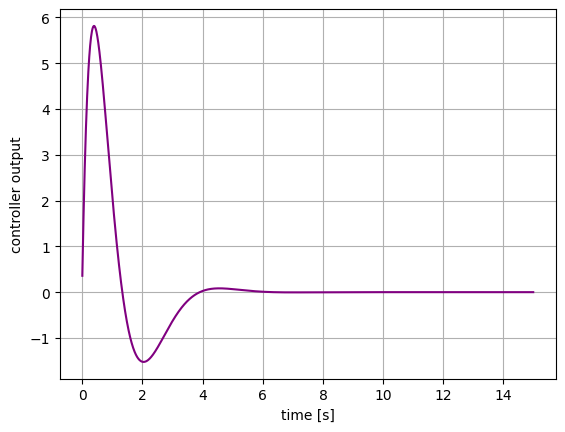

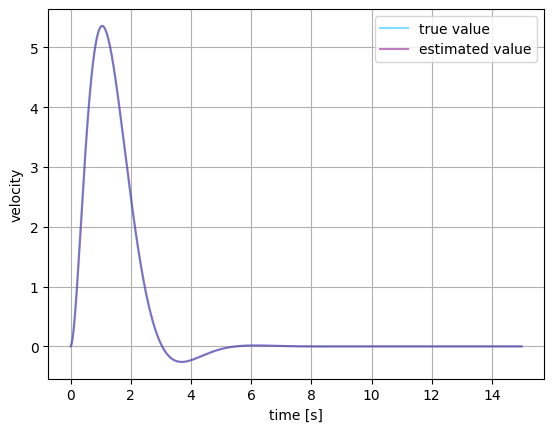

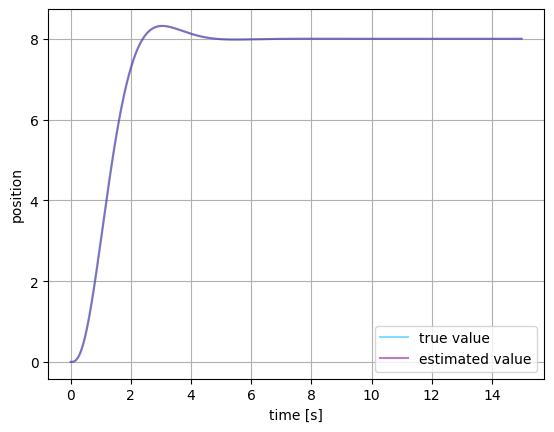

In [19]:
#closed loop step response
dt          = 0.01
steps       = 1500
t_result    = numpy.arange(steps)*dt

#required state, position = 8
yr          = numpy.zeros((1, 1))
yr[0][0]    = 8.0

#initial state
x           = numpy.zeros((2, 1))

#estimated state using Kalman observer
x_hat       = numpy.zeros((2, 1))

#kalman estimator needs observed output and input into plant 
y           = numpy.zeros((1, 1))
u           = numpy.zeros((1, 1))

#integral action error
e_int       = numpy.zeros((1, 1))

#resulted states for ploting
u_result        = numpy.zeros((steps, 1))
x_result        = numpy.zeros((steps, 2))
x_hat_result    = numpy.zeros((steps, 2))

for i in range(steps):
    #kalman observer
    #estimate x_hat from observed y, and u
    y_hat   = c@x_hat
    e       = y - y_hat
    dx_hat  = a@x_hat + b@u + f@e
    x_hat   = x_hat + dx_hat*dt

    #compute integral action
    error = yr - y
    e_int = e_int + error*dt

    #apply LQR control law with integral action
    u = -k@x_hat + h@e_int

    #dynamical system step
    dx = a@x + b@u
    y  = c@x
    x  = x + dx*dt
    
    u_result[i]     = u[0][0]
    x_hat_result[i] = x_hat[:, 0]
    x_result[i]     = x[:, 0]
    y_result[i]     = y[:, 0]

#plot response
plt.clf()
plt.ylabel("controller output")
plt.xlabel("time [s]")
plt.plot(t_result, u_result[:, 0], color="purple")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("velocity")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 0], color="deepskyblue", label = "true value", alpha=0.5)
plt.plot(t_result, x_hat_result[:, 0], color="purple", label = "estimated value", alpha=0.5)
plt.legend()
plt.grid()
plt.show()

plt.clf()
plt.ylabel("position")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 1], color="deepskyblue", label = "true value", alpha=0.5)
plt.plot(t_result, x_hat_result[:, 1], color="purple", label = "estimated value", alpha=0.5)
plt.legend()
plt.grid()
plt.show()

# adding disturbance

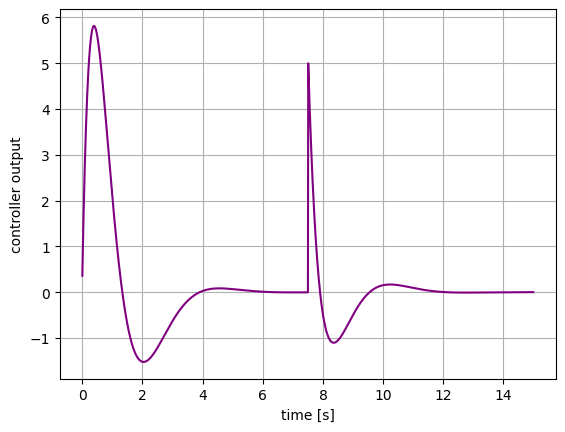

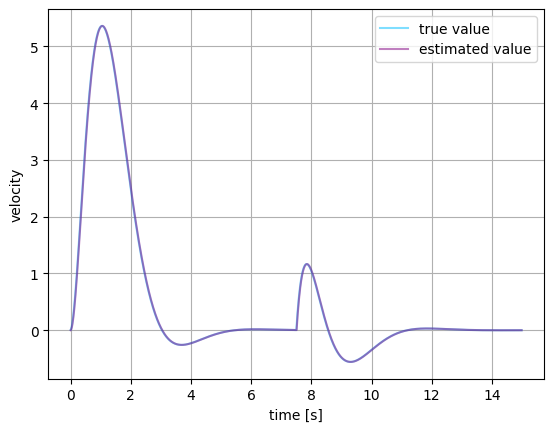

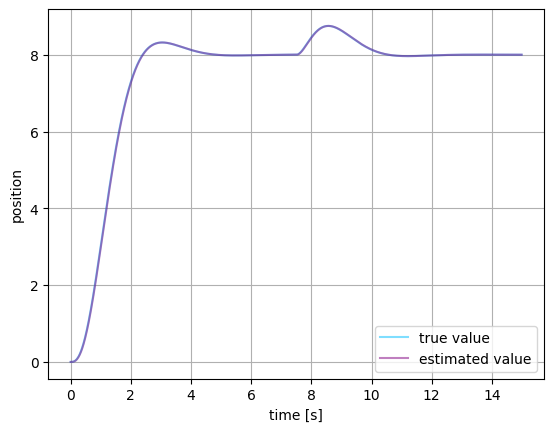

In [20]:
#closed loop step response
dt          = 0.01
steps       = 1500
t_result    = numpy.arange(steps)*dt

#required state, position = 8
yr          = numpy.zeros((1, 1))
yr[0][0]    = 8.0

#initial state
x           = numpy.zeros((2, 1))

#estimated state using Kalman observer
x_hat       = numpy.zeros((2, 1))

#kalman estimator needs observed output and input into plant 
y           = numpy.zeros((1, 1))
u           = numpy.zeros((1, 1))

#integral action error
e_int       = numpy.zeros((1, 1))

#resulted states for ploting
u_result        = numpy.zeros((steps, 1))
x_result        = numpy.zeros((steps, 2))
x_hat_result    = numpy.zeros((steps, 2))

for i in range(steps):
    #kalman observer
    #estimate x_hat from observed y, and u
    y_hat   = c@x_hat
    e       = y - y_hat
    dx_hat  = a@x_hat + b@u + f@e
    x_hat   = x_hat + dx_hat*dt

    #compute integral action
    error = yr - y
    e_int = e_int + error*dt

    #apply LQR control law with integral action
    u = -k@x_hat + h@e_int

    if i > steps//2:
        u+= 5.0

    #dynamical system step
    dx = a@x + b@u
    y  = c@x
    x  = x + dx*dt
    
    u_result[i]     = u[0][0]
    x_hat_result[i] = x_hat[:, 0]
    x_result[i]     = x[:, 0]
    y_result[i]     = y[:, 0]

#plot response
plt.clf()
plt.ylabel("controller output")
plt.xlabel("time [s]")
plt.plot(t_result, u_result[:, 0], color="purple")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("velocity")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 0], color="deepskyblue", label = "true value", alpha=0.5)
plt.plot(t_result, x_hat_result[:, 0], color="purple", label = "estimated value", alpha=0.5)
plt.legend()
plt.grid()
plt.show()

plt.clf()
plt.ylabel("position")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 1], color="deepskyblue", label = "true value", alpha=0.5)
plt.plot(t_result, x_hat_result[:, 1], color="purple", label = "estimated value", alpha=0.5)
plt.legend()
plt.grid()
plt.show()

# noisy state

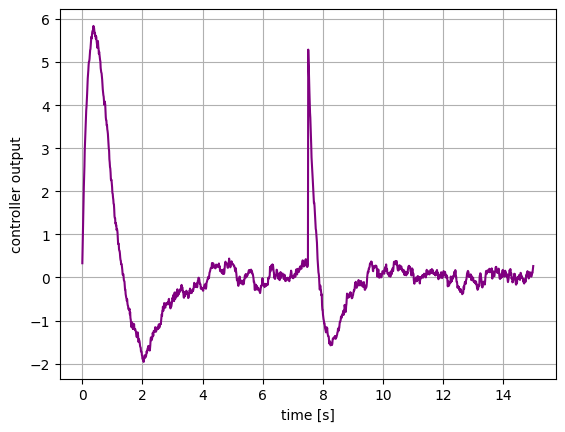

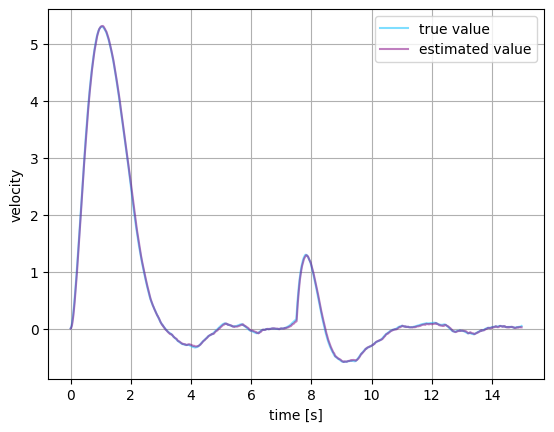

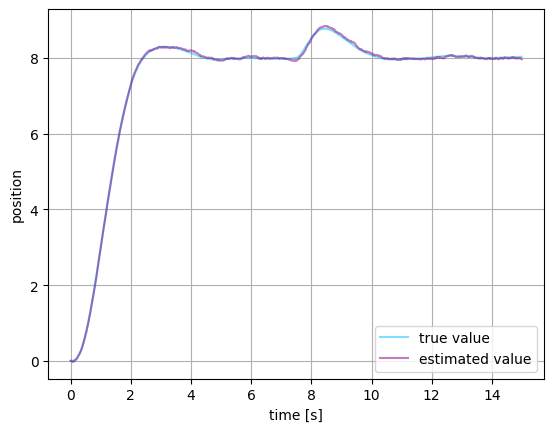

In [21]:
#closed loop step response
dt          = 0.01
steps       = 1500
t_result    = numpy.arange(steps)*dt

#required state, position = 8
yr          = numpy.zeros((1, 1))
yr[0][0]    = 8.0

#initial state
x           = numpy.zeros((2, 1))

#estimated state using Kalman observer
x_hat       = numpy.zeros((2, 1))

#kalman estimator needs observed output and input into plant 
y           = numpy.zeros((1, 1))
u           = numpy.zeros((1, 1))

#integral action error
e_int       = numpy.zeros((1, 1))

#resulted states for ploting
u_result        = numpy.zeros((steps, 1))
x_result        = numpy.zeros((steps, 2))
x_hat_result    = numpy.zeros((steps, 2))

for i in range(steps):
    y_noised = y + 0.25*numpy.random.randn(1, 1)

    #kalman observer
    #estimate x_hat from observed y, and u
    y_hat   = c@x_hat
    e       = y_noised - y_hat
    dx_hat  = a@x_hat + b@u + f@e
    x_hat   = x_hat + dx_hat*dt

    #compute integral action
    error = yr - y_noised
    e_int = e_int + error*dt

    #apply LQR control law with integral action
    u = -k@x_hat + h@e_int

    if i > steps//2:
        u+= 5.0

    #dynamical system step
    dx = a@x + b@u
    y  = c@x
    x  = x + dx*dt
    
    u_result[i]     = u[0][0]
    x_hat_result[i] = x_hat[:, 0]
    x_result[i]     = x[:, 0]
    y_result[i]     = y[:, 0]

#plot response
plt.clf()
plt.ylabel("controller output")
plt.xlabel("time [s]")
plt.plot(t_result, u_result[:, 0], color="purple")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("velocity")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 0], color="deepskyblue", label = "true value", alpha=0.5)
plt.plot(t_result, x_hat_result[:, 0], color="purple", label = "estimated value", alpha=0.5)
plt.legend()
plt.grid()
plt.show()

plt.clf()
plt.ylabel("position")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 1], color="deepskyblue", label = "true value", alpha=0.5)
plt.plot(t_result, x_hat_result[:, 1], color="purple", label = "estimated value", alpha=0.5)
plt.legend()
plt.grid()
plt.show()
